Import tools

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import scipy.linalg

Create a function which will make the piecewise linear basis elements for the functions space S in the Ritz-Galerkin approximation

In [ ]:
def create_b(n, res, f, dirichlet):
  # n determines the number of basis functions
  h = 1/(n-1)
  x_i = h
  x = np.linspace(0, 1, res)
  phi = []
  b = np.zeros((n,))
  if dirichlet:
    endpoint = n-1
  else:
    endpoint = n

  for i in range(1, endpoint):
    phi_i = np.zeros((res,))
    # create the basis functions on a fine grid to get a good estimate of the integral
    for j in range(len(x)):
      if x[j] >= (x_i-h) and x[j] <= x_i:
        phi_i[j] = (x[j] - (x_i-h))/h
      elif x[j] >= x_i and x[j] <= (x_i+h):
        phi_i[j] = ((x_i+h) - x[j])/h
    # now integrate the given f against this basis function
    phi.append(phi_i)
    b[i] = scipy.integrate.simps(np.multiply(f, phi_i), x)
    x_i += h

    # enfore the boundary conditions
    b[0] = f[0]
    b[1] = b[1] + 2*f[0]
    if dirichlet:
      b[-1] = 0
    
  return b, phi

Create the stiffness matrix in order to determine the weights on the piecewise linear functions. The first row and column will be zero except the $A_{1,1}$ entry which will be 1. This has the effect of solving the system on the interior nodes and forcing the right hand boundary to be zero for our essential Dirichlet boundary condition $u(0)=0$. The left side boundary condition $u'(1)=0$ is a natural boundary condition and no modification is needed at the moment

In [ ]:
def stiffness(n, dirichlet):
  h = 1/(n-1)
  # A is a tridiagonal matrix with 2/h on the diagonal and -1/h on the off-diagonal
  diagonal = [2/h for i in range(n)]
  diagonal_up = [-1/h for i in range(n-1)]
  diagonal_down = [-1/h for i in range(n-1)]
  A = np.diag(diagonal) + np.diag(diagonal_up, 1) + np.diag(diagonal_down, -1)

  # now enforce the boundary condition
  A[:, 0] = 0
  A[0, :] = 0
  A[0, 0] = 1
  if dirichlet:
    A[:, -1] = 0
    A[-1, :] = 0
    A[n-2, n-2] = 1/h
    A[n-1, n-1] = 1
  else:
    A[n-1, n-1] = 1/h
  return A

Given an $f(x)$ in Poisson's equation and a true solution, compare the convergence of the Finite Element solution to the true solution as the grid spacing decreases by powers of 2

In [ ]:
def convergence_analysis(f, u_true, dirichlet):
  grid_res = np.array([(2**2)+1, (2**3)+1, (2**4)+1, (2**5)+1, (2**6)+1, (2**7)+1, (2**8)+1, (2**9)+1, (2**10)+1])
  h_array = np.divide(1, (grid_res-1))
  integral_res = 1025
  errors = []
  upper_bound_errors = []
  x = np.linspace(0, 1, integral_res)
  # l2norm_f = np.sqrt(scipy.integrate.simps(f**2, x))

  for count, i in enumerate(grid_res):
    A = stiffness(i, dirichlet)

    b, basis = create_b(i, integral_res, f, dirichlet)

    alpha = scipy.linalg.solve(A, b)

    u = np.zeros((integral_res,))
    if dirichlet:
        endpoint = i-2
    else:
        endpoint = i-1
    for j in range(endpoint):
      u += np.multiply(alpha[j], basis[j])

    l2_error = np.sqrt(scipy.integrate.simps((u-u_true)**2, x))
    errors.append(l2_error)
    upper_bound_errors.append((h_array[count]**2))

  return errors, upper_bound_errors

The right hand side in the matrix equation we want to solve has entries that are the inner products of the piecewise linear functions and the f(x): $b_i = \int_0^1 \phi_i f$. A separate finer mesh is created to approximate this integral using simpsons rule

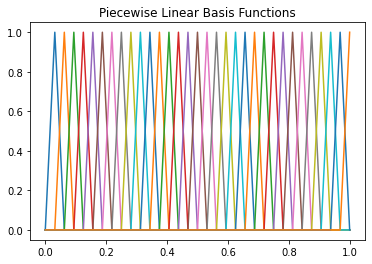

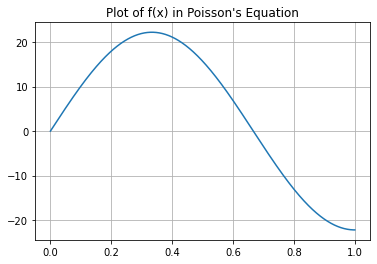

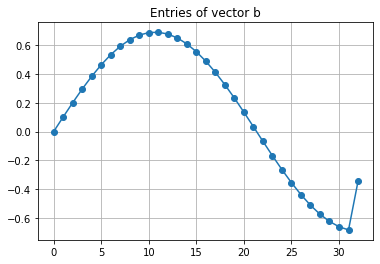

In [ ]:
# grid resolutions and frequency factor in sin
n = 33 # these are the nodes/mesh points including 0 and 1, so we will have n-1 basis functions
k = 1
integral_res = 1025

# create the stiffness matrix and the forcing function
A = stiffness(n, False)

# integrate <phi, f>
x = np.linspace(0, 1, integral_res)
f = ((k+(1/2))**2)*(np.pi**2)*np.sin((k+1/2)*np.pi*x)
u_true = np.sin((k+1/2)*np.pi*x)
b, basis = create_b(n, integral_res, f, False)

# plot the basis functions
for i in range(n-1):
  plt.plot(x, basis[i])
  plt.title('Piecewise Linear Basis Functions')
  plt.grid()

# plot f(x)
plt.figure()
plt.plot(x, f)
plt.title('Plot of f(x) in Poisson\'s Equation')
plt.grid()

# plot b
plt.figure()
plt.plot(b, marker='o')
plt.title('Entries of vector b')
plt.grid()

Now solve the system $A\alpha=b$ for the coefficients on the basis functions $\phi_i$ to create our Finite Element approximation $u_{FE}$ of the true solution $u$ to Poisson's equation. Then plot and compare the approximation and the true solution

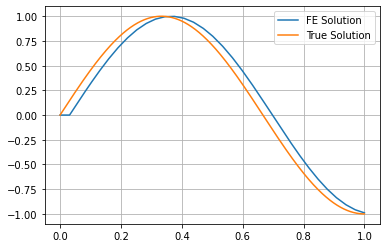

In [ ]:
alpha = scipy.linalg.solve(A, b)

u = np.zeros((integral_res,))
for i in range(n-1):
  u += np.multiply(alpha[i], basis[i])

plt.plot(x, u)
plt.plot(x, u_true)
plt.grid()
plt.legend(['FE Solution', 'True Solution'])

Visually this looks pretty good!

Now vary the grid spacing $h$ and plot the $L^2$ error, that is the integral of the squared difference between the true solution and the FE element approximation. This is for the smooth eigenfunction $f(x)=(k+\frac{1}{2})^2\pi^2\mathbb{sin}((k+\frac{1}{2})\pi)$. We set $k=1$.

In [ ]:
k = 1
f = ((k+(1/2))**2)*(np.pi**2)*np.sin((k+1/2)*np.pi*x)
u_true = np.sin((k+1/2)*np.pi*x)

errors_smooth, upper_bound_errors_smooth = convergence_analysis(f, u_true, False)

Plot the errors as a function of $h$ when it is decreased by a factor of $\frac{1}{2}$

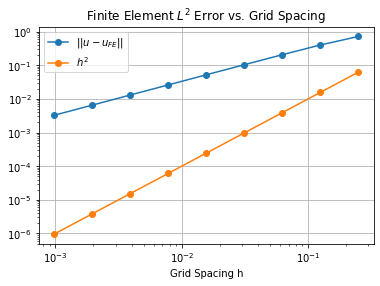

In [ ]:
grid_res = np.array([(2**2)+1, (2**3)+1, (2**4)+1, (2**5)+1, (2**6)+1, (2**7)+1, (2**8)+1, (2**9)+1, (2**10)+1])
h_array = np.divide(1, (grid_res-1))

plt.figure()
plt.plot(h_array, errors_smooth, marker='o')
plt.plot(h_array, upper_bound_errors_smooth, marker='o')
plt.xlabel('Grid Spacing h')
plt.grid()
plt.title('Finite Element $L^2$ Error vs. Grid Spacing')
plt.legend(['$||u-u_{FE}||$', '$h^2$'])
plt.xscale('log')
plt.yscale('log')

We can see from the above two plots that the error as a function of $h$ is close to the expected dependence on $h^2$. That is, the error $||u-u_{FE}||_{L^2}$ has a similar slope to $h^2$ as predicted by the inequality we derived in class $||u-u_{FE}||_{L^2}\leq \frac{h^{2}}{2}||f||_{L^2}$. The differences in the slopes could be explained by numerical error in the integration process, although a very fine grid was used with Simpson's rule. Ideally we would see the error go to zero at the same rate or faster than $h^2$ since it is an upper bound.

Change the stiffness matrix to force a boundary value of zero at the right endpoint and explore different regularities of $f(x)$. Choose the $f(x)$ as a step function that when integrated twice gives a $C^1$ function that obeys the Dirichlet boundary conditions 

Text(0.5, 1.0, 'Finite Element Solution vs. True Solution for Discontinuous $f(x)$')

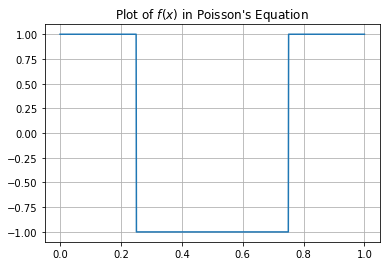

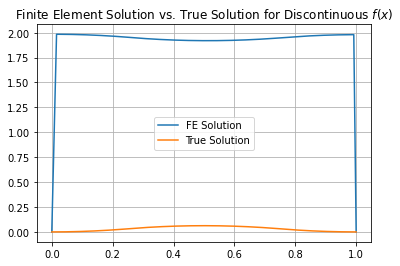

In [ ]:
n = 129
integral_res = 1025

A = stiffness(n, True)

x = np.linspace(0, 1, integral_res)
f = np.zeros((integral_res,))
g = np.zeros((integral_res,))
u_true = np.zeros((integral_res,))

# create f and the true solution u
for j in range(len(x)):
  if x[j] <= 1/4:
    f[j] = 1
    g[j] = x[j]
    u_true[j] = ((x[j]**2)/2)
  elif x[j] > 1/4 and x[j] <= 3/4:
    f[j] = -1
    g[j] = -x[j] + 1/2
    u_true[j] = -((x[j]**2)/2) + x[j]/2 - 1/16
  elif x[j] > 3/4:
    f[j] = 1
    g[j] = x[j] - 1
    u_true[j] = ((x[j]**2)/2) - x[j] + 1/2

b, basis = create_b(n, integral_res, f, True)

# plot f(x)
plt.figure()
plt.plot(x, f)
plt.title('Plot of $f(x)$ in Poisson\'s Equation')
plt.grid()

# plot integral of f(x)
plt.figure()
plt.plot(x, g)
plt.title('Plot of integral of $f(x)$ in Poisson\'s Equation')
plt.grid()

# plot of our true solution
plt.figure()
plt.plot(x, u_true)
plt.title('Plot of solution to Poisson\'s Equation')
plt.grid()

alpha = scipy.linalg.solve(A, b)

u = np.zeros((integral_res,))
for i in range(n-2):
  u += np.multiply(alpha[i], basis[i])

plt.figure()
plt.plot(x, u)
plt.plot(x, u_true)
plt.grid()
plt.legend(['FE Solution', 'True Solution'])
plt.title('Finite Element Solution vs. True Solution for Discontinuous $f(x)$')

This discontinuous function is giving Finite Elements difficulty. There are two huge spikes at the boundaries, even for a very fine mesh. It is interesting that the portion in the middle resembles the shape of the true solution.

Repeat the analysis from before so that we can compare rates of convergence

In [ ]:
errors_disc, upper_bound_errors_disc = convergence_analysis(f, u_true, True)

Plot errors as a function of $h$

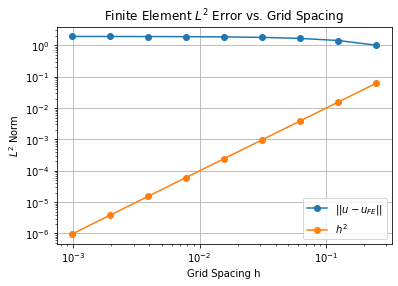

In [ ]:
plt.figure()
plt.plot(h_array, errors_disc, marker='o')
plt.plot(h_array, upper_bound_errors_disc, marker='o')
plt.xlabel('Grid Spacing h')
plt.ylabel('$L^2$ Norm')
plt.grid()
plt.title('Finite Element $L^2$ Error vs. Grid Spacing')
plt.legend(['$||u-u_{FE}||$', '$h^2$'])
plt.xscale('log')
plt.yscale('log')

The error here shows no indication of going to zero, let alone following the slope of the $h^2$ curve! This is drastically different from the case where $f(x)$ was smooth as in part a) where our convergence to zero had a similar slope to $h^2$

Now choose the $f(x)$ as a piecewise linear function that when integrated twice gives a $C^2$ function that obeys the Dirichlet boundary conditions 

Text(0.5, 1.0, 'Finite Element Solution vs. True Solution for $f(x)$ in $C^0$')

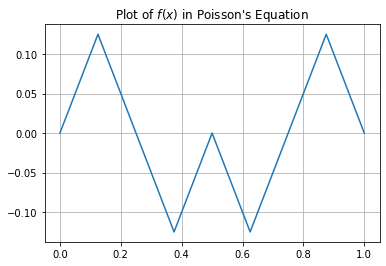

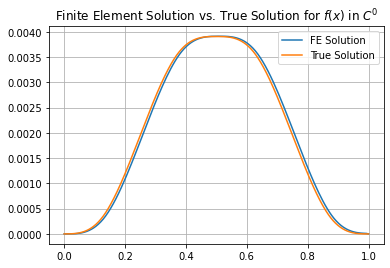

In [ ]:
n = 129
integral_res = 1025

A = stiffness(n, True)

x = np.linspace(0, 1, integral_res)
f = np.zeros((integral_res,))
g = np.zeros((integral_res,))
u_true = np.zeros((integral_res,))

# create f and the true solution u
for j in range(len(x)):
  if x[j] <= 1/8:
    f[j] = x[j]
    g[j] = (x[j]**2)/2
    u_true[j] = (x[j]**3)/6
  elif x[j] > 1/8 and x[j] <= 3/8:
    f[j] = -x[j] + 1/4
    g[j] = ((-x[j]**2)/2) + ((x[j])/4) - 1/64
    u_true[j] = ((-x[j]**3)/6) + ((x[j]**2)/8) - ((x[j])/64) + 1/1536
  elif x[j] > 3/8 and x[j] <= 1/2:
    f[j] = x[j] - 1/2
    g[j] = ((x[j]**2)/2) - ((x[j])/2) + 1/8
    u_true[j] = ((x[j]**3)/6) - ((x[j]**2)/4) + ((x[j])/8) - 13/768
  elif x[j] > 1/2 and x[j] <= 5/8:
    f[j] = -x[j] + 1/2
    g[j] = (-(x[j]**2)/2) + ((x[j])/2) - 1/8
    u_true[j] = ((-x[j]**3)/6) + ((x[j]**2)/4) - ((x[j])/8) + 19/768
  elif x[j] > 5/8 and x[j] <= 7/8:
    f[j] = x[j] - 3/4
    g[j] = ((x[j]**2)/2) - (3*(x[j])/4) + 17/64
    u_true[j] = ((x[j]**3)/6) - (3*(x[j]**2)/8) + (34*(x[j])/128) - 29/512
  elif x[j] > 7/8:
    f[j] = -x[j] + 1
    g[j] = (-(x[j]**2)/2) + x[j] - 1/2
    u_true[j] = -((x[j]**3)/6) + ((x[j]**2)/2) - ((x[j])/2) + 1/6

b, basis = create_b(n, integral_res, f, True)

# plot f(x)
plt.figure()
plt.plot(x, f)
plt.title('Plot of $f(x)$ in Poisson\'s Equation')
plt.grid()

# plot integral of f(x)
plt.figure()
plt.plot(x, g)
plt.title('Plot of integral of $f(x)$ in Poisson\'s Equation')
plt.grid()

# plot of our true solution
plt.figure()
plt.plot(x, u_true)
plt.title('Plot of solution to Poisson\'s Equation')
plt.grid()

alpha = scipy.linalg.solve(A, b)

u = np.zeros((integral_res,))
for i in range(n-2):
  u += np.multiply(alpha[i], basis[i])

plt.figure()
plt.plot(x, -u)
plt.plot(x, u_true)
plt.grid()
plt.legend(['FE Solution', 'True Solution'])
plt.title('Finite Element Solution vs. True Solution for $f(x)$ in $C^0$')

Now since $f(x)$ is continuous, Finite Elements is able to construct a great approximation to the true solution

Repeat the analysis from part a) so that we can compare rates of convergence

In [ ]:
errors_cont, upper_bound_errors_cont = convergence_analysis(-f, u_true, True)

Plot errors as a function of $h$

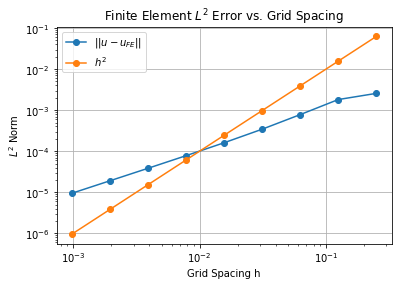

In [ ]:
plt.figure()
plt.plot(h_array, errors_cont, marker='o')
plt.plot(h_array, upper_bound_errors_cont, marker='o')
plt.xlabel('Grid Spacing h')
plt.ylabel('$L^2$ Norm')
plt.grid()
plt.title('Finite Element $L^2$ Error vs. Grid Spacing')
plt.legend(['$||u-u_{FE}||$', '$h^2$'])
plt.xscale('log')
plt.yscale('log')

This is much better than the case where $f(x)$ was discontinuous above. Here we see convergence to zero, with a slope that is similar to that of $h^2$. Previously, the slope was zero.

Summarize and compare the three cases of a smooth, discontinuous, and continuous $f(x)$ by creating a plot combining the above results

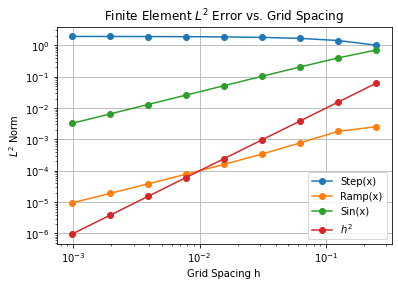

In [ ]:
plt.figure()
plt.plot(h_array, errors_disc, marker='o')
plt.plot(h_array, errors_cont, marker='o')
plt.plot(h_array, errors_smooth, marker='o')
plt.plot(h_array, upper_bound_errors_cont, marker='o')
plt.xlabel('Grid Spacing h')
plt.ylabel('$L^2$ Norm')
plt.grid()
plt.title('Finite Element $L^2$ Error vs. Grid Spacing')
plt.legend(['Step(x)', 'Ramp(x)', 'Sin(x)', '$h^2$'])
plt.xscale('log')
plt.yscale('log')

The discontinuous step function (blue) gives Finite Elements difficulty and shows no indication of converging. It has a constant slope and $L^2$ errors of approximately 1 across a wide range of mesh sizes. This is believable, since the true solution (obtained by integrating this function twice) only lives in $C^1$. Part of the construction in the Ritz-Galerkin approximation assumed that $f\in L^2 $ and $u\in C^2$, which is violated here.

The sawtooth or ramp function (orange) is continuous and so the true solution (again obtained by integrating the function twice) lives in $C^2$. Hence we see convergence to zero error in the $L^2$ norm. The smooth $\mathbb{sin}(x)$ (green) also lives in these function spaces, and so likewise we see convergence to zero error in the $L^2$ norm.

We don't see much of a difference between the smooth $\mathbb{sin}(x)$ and the $C^2$ solution built from the sawtooth or ramp function. The slopes of the two errors as a function of the grid spacing (green vs. orange) are almost identical. A priori, we might expect that the smoother the function, the steeper the slope of the error curve. Clearly, there is a difference in the slopes when comparing these two functions to the discontinuous step function.